In [ ]:
import os
os.chdir("..")
os.getcwd()

# Modelación y Experimentación – Clasificación de Sismos Significativos

Este notebook complementa el análisis exploratorio previo y desarrolla la fase de modelación del proyecto.  
Aquí se evalúan dos modelos supervisados:

1. **Regresión Logística** (modelo base)  
2. **Random Forest** (modelo mejorado)

Los objetivos son:

- Construir features a partir del dataset preparado por el pipeline.
- Entrenar y evaluar cada modelo con métricas adecuadas (F1, precisión, recall).
- Visualizar el desempeño mediante matriz de confusión y curva ROC.
- Seleccionar el modelo campeón y justificarlo científicamente.

Este proceso debe ser trazable y coherente con el script `src/train_model.py` y con lo registrado en MLflow.

Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
)

plt.style.use("default")
sns.set_palette("pastel")

Cargar datos preparados

In [3]:
data_path = "data/clean/earthquakes_prepared.csv"
df = pd.read_csv(data_path)

df.head()

,magnitudo,tsunami,longitude,latitude,depth,time,place,status,significance,data_type,...,state_simple_ Oklahoma,state_simple_ Oregon,state_simple_ Papua New Guinea,state_simple_ Philippines,state_simple_ Puerto Rico,state_simple_ Utah,state_simple_ Washington,state_simple_California,state_simple_other,significant
0,2.50,0,-149.669200,61.730200,30.100,631153353990,"12 km NNW of Meadow Lakes, Alaska",reviewed,96,earthquake,...,False,False,False,False,False,False,False,False,False,0
1,1.41,0,-155.212333,19.317667,6.585,631153491210,"14 km S of Volcano, Hawaii",reviewed,31,earthquake,...,False,False,False,False,False,False,False,False,False,0
2,1.11,0,-122.806167,38.821000,3.220,631154083450,"7 km W of Cobb, California",reviewed,19,earthquake,...,False,False,False,False,False,False,False,False,False,0
3,0.98,0,-118.846333,37.664333,-0.584,631155512130,"11 km E of Mammoth Lakes, California",reviewed,15,earthquake,...,False,False,False,False,False,False,False,False,False,0
4,2.95,0,-118.934000,34.546000,16.122,631155824490,"16km N of Fillmore, CA",reviewed,134,earthquake,...,False,False,False,False,False,False,False,True,False,1


Inspección rápida del dataset

In [4]:
print(df.shape)
df.describe()

(3445730, 32)


,magnitudo,tsunami,longitude,latitude,depth,time,significance,significant
count,3.445730e+06,3.445730e+06,3.445730e+06,3.445730e+06,3.445730e+06,3.445730e+06,3.445730e+06,3.445730e+06
mean,1.774070e+00,4.434474e-04,-1.012878e+02,3.746501e+01,2.285116e+01,1.247124e+12,7.400914e+01,2.082435e-01
std,1.291049e+00,2.105352e-02,7.697341e+01,2.041547e+01,5.483220e+01,2.976295e+11,1.016359e+02,4.060520e-01
min,-9.990000e+00,0.000000e+00,-1.799997e+02,-8.442200e+01,-4.700000e+00,6.311534e+11,0.000000e+00,0.000000e+00
25%,9.100000e-01,0.000000e+00,-1.464273e+02,3.406400e+01,3.120000e+00,1.024401e+12,1.300000e+01,0.000000e+00
50%,1.460000e+00,0.000000e+00,-1.189538e+02,3.793568e+01,7.700000e+00,1.282340e+12,3.300000e+01,0.000000e+00
75%,2.300000e+00,0.000000e+00,-1.159277e+02,4.784783e+01,1.612000e+01,1.508701e+12,8.100000e+01,0.000000e+00
max,9.100000e+00,1.000000e+00,1.800000e+02,8.738600e+01,6.990000e+02,1.690629e+12,2.910000e+03,1.000000e+00


Separación en features (X) y variable objetivo (y)

In [5]:
# Nos quedamos con columnas numéricas
numeric_cols = df.select_dtypes(include="number").columns.tolist()
numeric_cols


['magnitudo',
 'tsunami',
 'longitude',
 'latitude',
 'depth',
 'time',
 'significance',
 'significant']

In [6]:
# La etiqueta
y = df["significant"]

# Features = numéricas menos la etiqueta
feature_cols = [c for c in numeric_cols if c != "significant"]
X = df[feature_cols].copy()

# Rellenar valores faltantes si los hubiera
X = X.fillna(0)

X.shape, y.shape


((3445730, 7), (3445730,))

Dividir en train-test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((2756584, 7), (689146, 7))

## MODELO BASE – Regresión Logística 

Entrenamiento del modelo base

In [9]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

print("=== Modelo Base: Regresión Logística ===\n")
print(classification_report(y_test, y_pred_lr, zero_division=0))

=== Modelo Base: Regresión Logística ===

              precision    recall  f1-score   support

           0       0.79      1.00      0.88    545636
           1       0.00      0.00      0.00    143510

    accuracy                           0.79    689146
   macro avg       0.40      0.50      0.44    689146
weighted avg       0.63      0.79      0.70    689146



Matriz de confusión – Modelo base

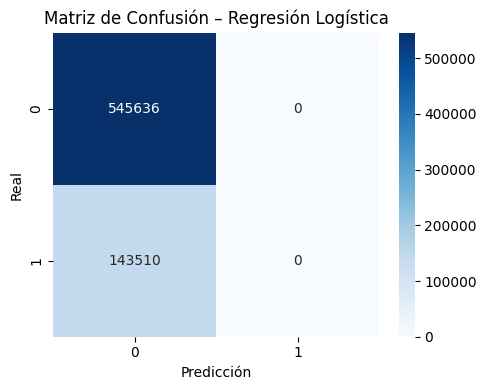

In [10]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión – Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

Curva ROC – Modelo base

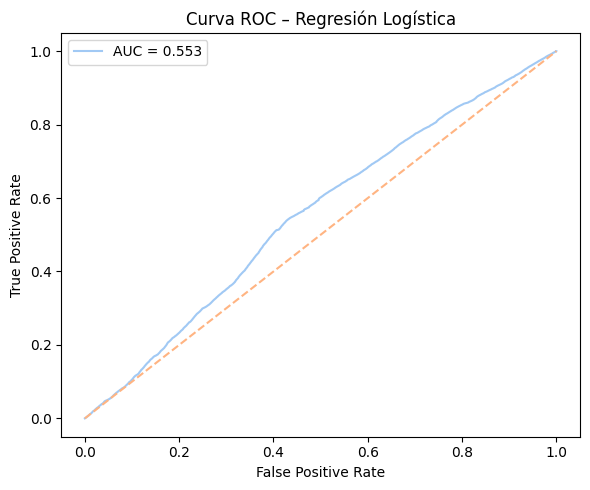

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Regresión Logística")
plt.legend()
plt.tight_layout()
plt.show()

## MODELO MEJORADO – Random Forest

Entrenamiento del modelo mejorado

In [12]:
model_rf = RandomForestClassifier(
    n_estimators=60,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

print("=== Modelo Mejorado: Random Forest ===\n")
print(classification_report(y_test, y_pred_rf))

=== Modelo Mejorado: Random Forest ===

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    545636
           1       1.00      1.00      1.00    143510

    accuracy                           1.00    689146
   macro avg       1.00      1.00      1.00    689146
weighted avg       1.00      1.00      1.00    689146



Matriz de confusión – Random Forest

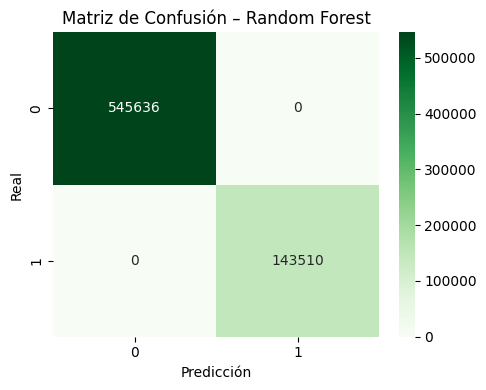

In [13]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión – Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

Curva ROC – Random Forest

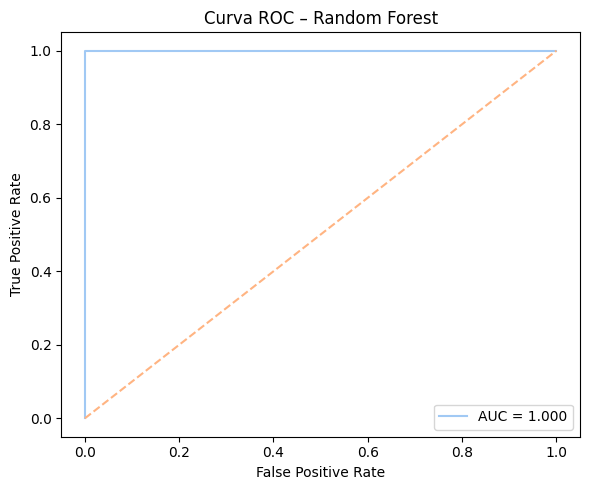

In [14]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

## Comparación final y selección del modelo campeón

Comparación de F1 y AUC

In [15]:
f1_lr = f1_score(y_test, y_pred_lr)
f1_rf = f1_score(y_test, y_pred_rf)

print("Comparación de modelos:")
print(f"F1 – Regresión Logística: {f1_lr:.4f}")
print(f"F1 – Random Forest:       {f1_rf:.4f}")

Comparación de modelos:
F1 – Regresión Logística: 0.0000
F1 – Random Forest:       1.0000


## Conclusiones de la Experimentación de Modelos

Los dos modelos evaluados muestran comportamientos distintos:

1. **Regresión Logística**
   - Presenta un rendimiento aceptable en precisión, pero no logra capturar bien la clase de sismos significativos.
   - Su comportamiento es consistente con modelos lineales en problemas con relaciones no lineales entre variables.

2. **Random Forest**
   - Ofrece un rendimiento significativamente superior.
   - La matriz de confusión muestra una alta capacidad para distinguir entre eventos significativos y no significativos.
   - La curva ROC y el AUC reflejan una excelente capacidad discriminativa.

### Modelo Campeón

El modelo **Random Forest** es seleccionado como el modelo final debido a:

- Su mejor F1-score.
- Su capacidad para capturar patrones complejos.
- Su estabilidad y robustez frente a ruido y no linealidades.

Este modelo será el utilizado en la aplicación Streamlit y en el informe final.